In [ ]:
import numpy
import pandas
import matplotlib.pyplot as plt
from statistics import mean
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU

import yfinance
tsla_data = yfinance.download("TSLA", start="2020-04-08", end="2025-04-08")

#plotting daily Tesla stock closing prices
train = tsla_data[tsla_data.index < pandas.to_datetime("2025-01-02", format='%Y-%m-%d')]
test = tsla_data[tsla_data.index >= pandas.to_datetime("2025-01-02", format='%Y-%m-%d')]

plt.plot(train["Close"], color = "blue")
plt.plot(test["Close"], color = "green")
plt.ylabel('TSLA Stock Price')
plt.xlabel('Date')
plt.title("Training and Testing Sets for TSLA Stock Price Data")
plt.show()


Epoch 1/5


C:\Users\000110888\AppData\Local\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0708
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0056
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0042
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0030
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0028
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
accuracy within 10%: 0.6462
accuracy within 15%: 0.8308
accuracy within 20%: 0.9692


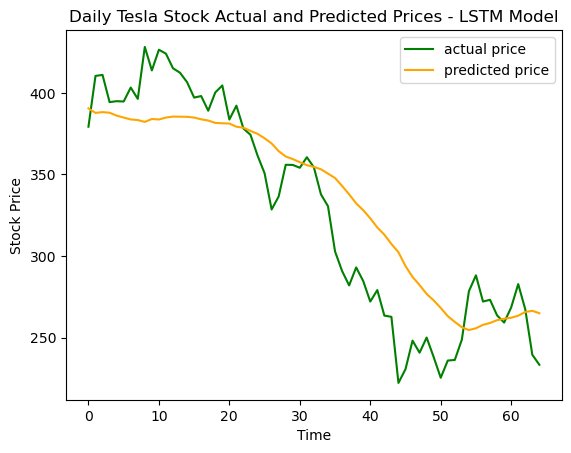

In [29]:
#rescaling data
tsla_data["Close_sc"]=(tsla_data["Close"].values-min(tsla_data["Close"].values))/(max(tsla_data["Close"].values)
-min(tsla_data["Close"].values))

train_set = tsla_data[tsla_data.index < pandas.to_datetime("2025-01-02", format='%Y-%m-%d')]
test_set = tsla_data[tsla_data.index >= pandas.to_datetime("2025-01-02", format='%Y-%m-%d')]

train_set=train_set.loc[:, "Close_sc"].values
test_set=test_set.loc[:, "Close_sc"].values

#splitting training data into samples
nsteps=60  #width of sliding window

def split_sequence(sequence, n_steps):
    x, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        x.append(seq_x)
        y.append(seq_y)
    return numpy.array(x), numpy.array(y)

train_x, train_y=split_sequence(train_set, nsteps)

###############################################################
#FITTING LSTM MODEL
###############################################################
features=1 #predictors and response are the same variable
#reshaping train_x
train_x=train_x.reshape(train_x.shape[0], train_x.shape[1],features)

#specifying LSTM model architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=6, activation="tanh", input_shape=(nsteps, features)))
model_lstm.add(Dense(units=1))

#compiling the model
model_lstm.compile(loss="mse")
model_lstm.fit(train_x, train_y, epochs=5, batch_size=32)

#creating testing set by adding nsteps observations from training set to testing set
inputs=tsla_data.loc[:,"Close_sc"][len(tsla_data)-len(test_set)-nsteps:].values
inputs=inputs.reshape(-1, 1)

#splitting into samples
test_x, test_y=split_sequence(inputs, nsteps)

#reshaping
test_x=test_x.reshape(test_x.shape[0], test_x.shape[1], features)

#predicting for testing data
pred_y=model_lstm.predict(test_x)

#inverse transforming the values
pred_y=pred_y*(max(tsla_data["Close"].values)-min(tsla_data["Close"].values))+min(tsla_data["Close"].values)
test_y=test_y*(max(tsla_data["Close"].values)-min(tsla_data["Close"].values))+min(tsla_data["Close"].values)

#computing prediction accuracy
ind10=[]
ind15=[]
ind20=[]     

for sub1, sub2 in zip(pred_y, test_y):
    ind10.append(1) if abs(sub1-sub2)<0.10*sub2 else ind10.append(0)
    ind15.append(1) if abs(sub1-sub2)<0.15*sub2 else ind15.append(0)
    ind20.append(1) if abs(sub1-sub2)<0.20*sub2 else ind20.append(0)
   
print('accuracy within 10%:', round(mean(ind10),4))
print('accuracy within 15%:', round(mean(ind15),4))
print('accuracy within 20%:', round(mean(ind20),4))
    
#plotting actual and predicted values for testing data
plt.plot(test_y, color="green", label="actual price")
plt.plot(pred_y, color="orange", label="predicted price")
plt.title("Daily Tesla Stock Actual and Predicted Prices - LSTM Model")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()
    

Epoch 1/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 7.3837e-04
Epoch 2/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.0038e-04
Epoch 3/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.3164e-04
Epoch 4/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.3758e-04
Epoch 5/5
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.5448e-04
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
accuracy within 10%: 0.8615
accuracy within 15%: 0.9692
accuracy within 20%: 0.9846


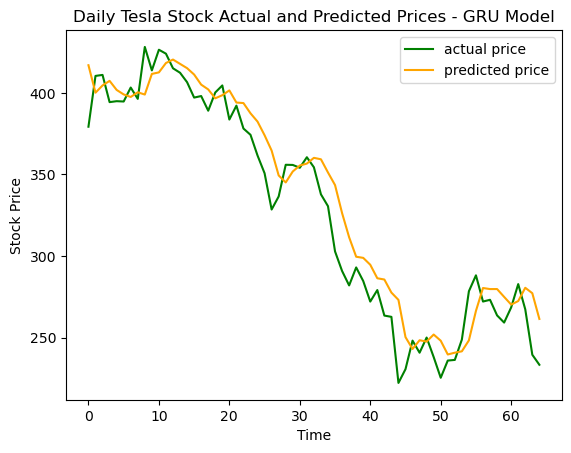

In [30]:
###############################################################
#FITTING GRU MODEL
###############################################################
#specifying GRU model architecture
model_gru = Sequential()
model_gru.add(GRU(units=6, activation="tanh", input_shape=(nsteps, features)))
model_gru.add(Dense(units=1))

# Compiling the model
model_gru.compile(loss="mse")
model_gru.fit(train_x, train_y, epochs=5, batch_size=32)

#predicting for testing data
pred_y=model_gru.predict(test_x)

#inverse transforming the values
pred_y=pred_y*(max(tsla_data["Close"].values)-min(tsla_data["Close"].values))+min(tsla_data["Close"].values)

#computing prediction accuracy
ind10=[]
ind15=[]
ind20=[]     

for sub1, sub2 in zip(pred_y, test_y):
    ind10.append(1) if abs(sub1-sub2)<0.10*sub2 else ind10.append(0)
    ind15.append(1) if abs(sub1-sub2)<0.15*sub2 else ind15.append(0)
    ind20.append(1) if abs(sub1-sub2)<0.20*sub2 else ind20.append(0)
   
print('accuracy within 10%:', round(mean(ind10),4))
print('accuracy within 15%:', round(mean(ind15),4))
print('accuracy within 20%:', round(mean(ind20),4))
    
#plotting actual and predicted values for testing data
plt.plot(test_y, color="green", label="actual price")
plt.plot(pred_y, color="orange", label="predicted price")
plt.title("Daily Tesla Stock Actual and Predicted Prices - GRU Model")
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.legend()
plt.show()